# Inverse PINN-HM for Barry-Mercer Injection/Production  

Check out our paper for more details: 
**Inverse modeling of nonisothermal multiphase poromechanics using physics-informed neural networks**

Find the paper at: [https://arxiv.org/abs/2209.03276](https://arxiv.org/abs/2209.03276)

Try it out on Google Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciann/sciann-applications/blob/master/SciANN-PoroElasticity/PINN_THM_TwoPhaseConsolidation.ipynb)


Cite our work:
```
@article{amini2022inverse,
  title={Inverse modeling of nonisothermal multiphase poromechanics using physics-informed neural networks},
  author={Amini, Danial and Haghighat, Ehsan and Juanes, Ruben},
  journal={arXiv preprint arXiv:2209.03276},
  year={2022}
}
```

In [1]:
# !pip install sciann  

In [2]:
import numpy as np 
import sciann as sn 
from sciann.utils.math import sign, abs, sigmoid, tanh, diff, exp, sin, cos
import os, time 
import matplotlib.pyplot as plt

---------------------- SCIANN 0.6.6.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)] 



In [3]:
# Unit conversions 
s, minute, hr, day = 1., 60., 60.**2, 24*60.**2
g, kg = 1.e-3, 1.
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9
micro, milli, centi, kilo, mega = 1e-6, 1e-3, 1e-2, 1e3, 1e6
poise = 0.1*Pa*s
Darcy = 9.869233e-13*m**2

In [4]:
# ----------------------- Neural Network Setup -----------------------

sn.reset_session()
sn.set_random_seed(124)
DTYPE = 'float32'

xd = sn.Variable('xd', dtype=DTYPE)
xf = sn.fourier(xd, w=np.random.normal(0,1,5))
yd = sn.Variable('yd', dtype=DTYPE)
yf = sn.fourier(yd, w=np.random.normal(0,1,5))
td = sn.Variable('td', dtype=DTYPE)
tf = sn.fourier(td, w=np.random.normal(0,1,5))

pd = sn.Functional('pd', [xf, yf, tf], 4*[100], 'tanh')
ud = sn.Functional('ud', [xf, yf, tf], 4*[100], 'tanh')
vd = sn.Functional('vd', [xf, yf, tf], 4*[100], 'tanh')
Evd = sn.Functional('Evd', [xf, yf, tf], 4*[100], 'tanh')

In [5]:
# ----------Parameters-----------

rho_b = 2400.0 * kg/m**3
rho_star = 2400. * kg/m**3
rho_b_bar = rho_b/rho_star

mu = 1. * centi * poise
mu_star = 1. * centi * poise
mu_bar = mu/mu_star

k = 1e-10
k_star = 1e-10
k_bar = sn.Parameter(2, non_neg=True, inputs=[xd, yd, td], name='k_bar')

E = 46.7e5
E_star = 46.7e5
E_bar = sn.Parameter(2, non_neg=True, inputs=[xd, yd, td], name='E_bar')

nu = 0.167
b = 1.0 
Lx = 1*m
Ly = 1*m

Kdr = E_bar*E_star/(3*(1-2*nu))
Kdr_star = E/(3*(1-2*nu))
Kdr_bar = Kdr/Kdr_star

Lame1 = E*nu/((1+nu)*(1-2*nu))
Lame2 = E/(2*(1+nu))


In [6]:
# ----------------------- Dimensionless parameters -----------------------
p_star = Lame1 + 2*Lame2
x_star = Lx
t_star = mu_star*(x_star**2)/(k_star*Kdr_star)
u_star = p_star*x_star/Kdr_star
D_star = mu_star*(x_star**2)/Kdr_star/k_star/t_star

beta = ((Lame1 + 2*Lame2)*k_star)/(mu_star*Lx**2)
f_star = 2*beta*mu_star*(x_star**2)/(k_star*p_star)

x = xd*x_star
y = yd*x_star
p = pd*p_star
t = td*t_star
u = ud*u_star    
v = vd*u_star    

x_source = 0.25
y_source = 0.25

td_0 = 0.0 
t_star_Barry = (mu_star*(x_star**2)/(p_star*k_star))
td_f = 2*np.pi*t_star_Barry/t_star   
xd_min = 0.0 
xd_max = (Lx/x_star) 
yd_min = 0.0 
yd_max = (Ly/x_star) 

In [7]:
# ----------------------- Solid Mechanics -----------------------

ud_xd, ud_yd = diff(ud, xd), diff(ud, yd)
vd_xd, vd_yd = diff(vd, xd), diff(vd, yd)

Exxd = ud_xd
Eyyd = vd_yd
Exyd = (ud_yd + vd_xd)*0.5

Svd = Kdr_bar*Evd - b*pd
Svd_td = diff(Svd, td)


Msx = sn.rename(Kdr_bar*diff(Evd, xd) + Kdr_bar*(1/2)*(1-2*nu)/(1+nu)*diff(ud_xd+vd_yd, xd) +
                Kdr_bar*(3/2)*(1-2*nu)/(1+nu)*(diff(ud_xd, xd) + diff(ud_yd, yd)) - b*diff(pd, xd), "Msx")

Msy = sn.rename(Kdr_bar*diff(Evd, yd) + Kdr_bar*(1/2)*(1-2*nu)/(1+nu)*diff(ud_xd+vd_yd, yd) +
                Kdr_bar*(3/2)*(1-2*nu)/(1+nu)*(diff(vd_xd, xd) + diff(vd_yd, yd)) - b*diff(pd, yd), "Msy")

MEv = sn.rename(ud_xd + vd_yd - Evd, "MEv")


C_u_ini = sn.rename((td == td_0)*abs(ud), "C_u_ini")
C_v_ini = sn.rename((td == td_0)*abs(vd), "C_v_ini")

C_u_bc_1 = sn.rename((xd == xd_min)*abs(Exxd), "C_u_bc_1") 
C_u_bc_2 = sn.rename((xd == xd_max)*abs(Exxd), "C_u_bc_2") 
C_u_bc_3 = sn.rename((yd == yd_min)*abs(ud), "C_u_bc_3")  
C_u_bc_4 = sn.rename((yd == yd_max)*abs(ud), "C_u_bc_4")

C_v_bc_1 = sn.rename((xd == xd_min)*abs(vd), "C_v_bc_1") 
C_v_bc_2 = sn.rename((xd == xd_max)*abs(vd), "C_v_bc_2") 
C_v_bc_3 = sn.rename((yd == yd_min)*abs(Eyyd), "C_v_bc_3")  
C_v_bc_4 = sn.rename((yd == yd_max)*abs(Eyyd), "C_v_bc_4")

targets_solid = [sn.PDE(Msx), sn.PDE(Msy), sn.PDE(MEv), C_u_ini, C_v_ini, 
                 C_u_bc_1, C_u_bc_2, C_u_bc_3, C_u_bc_4, 
                 C_v_bc_1, C_v_bc_2, C_v_bc_3, C_v_bc_4, ud, ud, vd, vd]


In [8]:
# ----------------------- Fluid Mechanics -----------------------

Svd_td_seq = sn.Variable('Svd_td_seq', dtype=DTYPE)
pd_xd, pd_yd, pd_td = diff(pd,xd), diff(pd,yd), diff(pd,td)

a = 0.04
injc_point = (1/(np.pi*a**2))*exp(-((xd-x_source)/a)**2)*exp(-((yd-y_source)/a)**2)

Mp = sn.rename(b**2/Kdr_bar*D_star*pd_td + b/Kdr_bar*D_star*Svd_td_seq - k_bar/mu_bar*(diff(pd_xd, xd)+diff(pd_yd, yd)) -
               f_star*injc_point*sin(td*t_star/t_star_Barry),"Mp")
                        
C_p_ini = sn.rename((td == td_0)*abs(pd), "C_p_ini")
C_q_bc_1 = sn.rename((yd == yd_max)*abs(pd), "C_q_bc_1")
C_q_bc_2 = sn.rename((yd == yd_min)*abs(pd), "C_q_bc_2")
C_q_bc_3 = sn.rename((xd == xd_min)*abs(pd), "C_q_bc_3") 
C_q_bc_4 = sn.rename((xd == xd_max)*abs(pd), "C_q_bc_4")

targets_fluid = [sn.PDE(Mp), C_p_ini, C_q_bc_1, C_q_bc_2, C_q_bc_3, C_q_bc_4, pd, pd]


In [9]:
# ----------------------- prediction model -----------------------
model_pred = sn.SciModel([xd,yd,td], [pd, ud, vd, Svd_td])

# ----definition of models for sequential process-------

solid = sn.SciModel([xd, yd, td], targets_solid)
fluid = sn.SciModel([xd, yd, td, Svd_td_seq], targets_fluid)

#------training parameters---------

BATCH_SIZE = 500          # higher batch size results in more accuracy (used for the paper results = 500)
EPOCHS_FLUID = 5000       # more epochs improve the accuracy (used for the paper results = 5000)
EPOCHS_SOLID = 5000       # more epochs improve the accuracy (used for the paper results = 5000)
STOP_AFTER = None
ADAPTIVE_WEIGHTS = {'method': 'GN', 'freq': 300, 'use_score': True, 'alpha': 1.0}



In [10]:
#@title Collocation Points for Analytical Solution, Sensors, and Model Evaluation 

# ----------grid for plot---------
log10p = lambda x: np.log10(1. + x)
Nx, Ny, Nt = 41, 41, 101
xs = np.linspace(xd_min, xd_max, Nx)  
ys = np.linspace(yd_min, yd_max, Ny)
ts = np.linspace(td_0, td_f, Nt) 
ts_contour = [0.0*td_f, 0.25*td_f, 0.5*td_f, 0.75*td_f, 1.0*td_f]

Xdtest_point, Ydtest_point, Tdtest_point = np.meshgrid(xs, ys, ts, indexing='ij')
input_test_point1 = [Xdtest_point[10,30,:], Ydtest_point[10,30,:], Tdtest_point[10,30,:]] # point1 == x=0.25, y=0.75
input_test_point2 = [Xdtest_point[30,30,:], Ydtest_point[30,30,:], Tdtest_point[30,30,:]] # point2 == x=0.75, y=0.75
input_test_point3 = [Xdtest_point[30,10,:], Ydtest_point[30,10,:], Tdtest_point[30,10,:]] # point3 == x=0.75, y=0.25


# ------- grid as input for model----------

xx = [0.0,0.05,0.1,0.15,0.175,0.2,0.225,0.250,0.275,0.3,0.325,0.35,0.4,0.45,0.5,0.6,0.7,0.8,0.9,1.0]
yy = [0.0,0.05,0.1,0.15,0.175,0.2,0.225,0.250,0.275,0.3,0.325,0.35,0.4,0.45,0.5,0.6,0.7,0.8,0.9,1.0]
tn = 41
tt = np.linspace(td_0, td_f, tn)
x_data, y_data, t_data = [v.reshape(-1,1) for v in np.meshgrid(xx, yy, tt)]
input_data = [x_data, y_data, t_data]

# ------sensor location-------
x_sensor_ids = np.where(np.logical_and(x_data.flatten() == xd_max/2, 
                                       np.logical_or(y_data.flatten() == 0.1, 
                                                     np.logical_or(y_data.flatten() == 0.4, y_data.flatten() == 0.8))))[0]
y_sensor_ids = np.where(np.logical_and(y_data.flatten() == yd_max/2, 
                                       np.logical_or(x_data.flatten() == 0.1, 
                                                     np.logical_or(x_data.flatten() == 0.4, x_data.flatten() == 0.8))))[0]


In [11]:
#@title Analytical Solution

#---------Analytical Solution-------
p_true_sensor = np.zeros_like(input_data[2])
u_true_sensor = np.zeros_like(input_data[2])
v_true_sensor = np.zeros_like(input_data[2])

p_true_point1 = np.zeros_like(input_test_point1[2])
u_true_point1 = np.zeros_like(input_test_point1[2])
v_true_point1 = np.zeros_like(input_test_point1[2])

p_true_point2 = np.zeros_like(input_test_point2[2])
u_true_point2 = np.zeros_like(input_test_point2[2])
v_true_point2 = np.zeros_like(input_test_point2[2])

p_true_point3 = np.zeros_like(input_test_point3[2])
u_true_point3 = np.zeros_like(input_test_point3[2])
v_true_point3 = np.zeros_like(input_test_point3[2])

x0 = 0.25
y0 = 0.25

td_Barry_sensor = input_data[2]*t_star*beta
td_Barry_point1 = input_test_point1[2]*t_star*beta
td_Barry_point2 = input_test_point2[2]*t_star*beta
td_Barry_point3 = input_test_point3[2]*t_star*beta


for n in np.arange(1,100,1):
    lambda_n = n*np.pi/Lx
    for q in np.arange(1,100,1):
        lambda_q = q*np.pi/Ly
        lambda_nq = lambda_n**2 + lambda_q**2
        
        ps_sensor = - (2.0*np.sin(lambda_n*x0)*np.sin(lambda_q*y0)/(lambda_nq**2+1))*(lambda_nq*np.sin(td_Barry_sensor) - np.cos(td_Barry_sensor) + np.exp(-lambda_nq * td_Barry_sensor))
        us_sensor = lambda_n * ps_sensor / lambda_nq
        vs_sensor = lambda_q * ps_sensor / lambda_nq
        p_true_sensor += ps_sensor * np.sin(lambda_n * input_data[0])*np.sin(lambda_q * input_data[1])
        u_true_sensor += us_sensor * np.cos(lambda_n * input_data[0])*np.sin(lambda_q * input_data[1])
        v_true_sensor += vs_sensor * np.sin(lambda_n * input_data[0])*np.cos(lambda_q * input_data[1])

        ps_point1 = - (2.0*np.sin(lambda_n*x0)*np.sin(lambda_q*y0)/(lambda_nq**2+1))*(lambda_nq*np.sin(td_Barry_point1) - np.cos(td_Barry_point1) + np.exp(-lambda_nq*td_Barry_point1))
        us_point1 = lambda_n*ps_point1/lambda_nq
        vs_point1 = lambda_q*ps_point1/lambda_nq
        p_true_point1 += ps_point1*np.sin(lambda_n*input_test_point1[0])*np.sin(lambda_q*input_test_point1[1])
        u_true_point1 += us_point1*np.cos(lambda_n*input_test_point1[0])*np.sin(lambda_q*input_test_point1[1])
        v_true_point1 += vs_point1*np.sin(lambda_n*input_test_point1[0])*np.cos(lambda_q*input_test_point1[1])

        ps_point2 = - (2.0*np.sin(lambda_n*x0)*np.sin(lambda_q*y0)/(lambda_nq**2+1))*(lambda_nq*np.sin(td_Barry_point2) - np.cos(td_Barry_point2) + np.exp(-lambda_nq*td_Barry_point2))
        us_point2 = lambda_n*ps_point2/lambda_nq
        vs_point2 = lambda_q*ps_point2/lambda_nq
        p_true_point2 += ps_point2*np.sin(lambda_n*input_test_point2[0])*np.sin(lambda_q*input_test_point2[1])
        u_true_point2 += us_point2*np.cos(lambda_n*input_test_point2[0])*np.sin(lambda_q*input_test_point2[1])
        v_true_point2 += vs_point2*np.sin(lambda_n*input_test_point2[0])*np.cos(lambda_q*input_test_point2[1])

        ps_point3 = - (2.0*np.sin(lambda_n*x0)*np.sin(lambda_q*y0)/(lambda_nq**2+1))*(lambda_nq*np.sin(td_Barry_point3) - np.cos(td_Barry_point3) + np.exp(-lambda_nq*td_Barry_point3))
        us_point3 = lambda_n*ps_point3/lambda_nq
        vs_point3 = lambda_q*ps_point3/lambda_nq
        p_true_point3 += ps_point3*np.sin(lambda_n*input_test_point3[0])*np.sin(lambda_q*input_test_point3[1])
        u_true_point3 += us_point3*np.cos(lambda_n*input_test_point3[0])*np.sin(lambda_q*input_test_point3[1])
        v_true_point3 += vs_point3*np.sin(lambda_n*input_test_point3[0])*np.cos(lambda_q*input_test_point3[1])

        

p_true_sensor = -(Lame1 + 2*Lame2)*p_true_sensor*4/Lx/Ly
u_true_sensor = Lx*u_true_sensor*4/Lx/Ly
v_true_sensor = Ly*v_true_sensor*4/Lx/Ly

pd_true_sensor_Xprescribed = p_true_sensor[x_sensor_ids].reshape(-1,1)/p_star
pd_true_sensor_Yprescribed = p_true_sensor[y_sensor_ids].reshape(-1,1)/p_star
ud_true_sensor_Xprescribed = u_true_sensor[x_sensor_ids].reshape(-1,1)/u_star
ud_true_sensor_Yprescribed = u_true_sensor[y_sensor_ids].reshape(-1,1)/u_star
vd_true_sensor_Xprescribed = v_true_sensor[x_sensor_ids].reshape(-1,1)/u_star
vd_true_sensor_Yprescribed = v_true_sensor[y_sensor_ids].reshape(-1,1)/u_star

p_true_point1 = -(Lame1 + 2*Lame2)*p_true_point1*4/Lx/Ly/MPa
u_true_point1 = Lx*u_true_point1*4/Lx/Ly/m
v_true_point1 = Ly*v_true_point1*4/Lx/Ly/m

p_true_point2 = -(Lame1 + 2*Lame2)*p_true_point2*4/Lx/Ly/MPa
u_true_point2 = Lx*u_true_point2*4/Lx/Ly/m
v_true_point2 = Ly*v_true_point2*4/Lx/Ly/m

p_true_point3 = -(Lame1 + 2*Lame2)*p_true_point3*4/Lx/Ly/MPa
u_true_point3 = Lx*u_true_point3*4/Lx/Ly/m
v_true_point3 = Ly*v_true_point3*4/Lx/Ly/m



In [12]:
#@title Post processing (plotting) functions 

def cust_semilogx(AX, X, Y, xlabel, ylabel, title, line_label=None):
    if X is None:
        im = AX.semilogy(Y, label=line_label)
    else:
        im = AX.semilogy(X, Y, label=line_label)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)
    if title  is not None: AX.set_title(title)  

def Loss_Plot(H_fluid, H_solid, itr):
    fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    for key, val in H_fluid.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[0, 0], None, np.array(val) / val[0], None, "Fluid", "L/L0", key)
    ax[0, 0].legend(loc="upper right")
    cust_semilogx(ax[0, 1], None, np.array(H_fluid.history["lr"]), None, None, "lr")
    cust_semilogx(ax[0, 2], None, np.array(H_fluid.history["time"]), None, None, "time")

    for key, val in H_solid.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[1, 0], None, np.array(val) / val[0], None, "Solid", None, key)
    ax[1, 0].legend(loc="upper right")
    cust_semilogx(ax[1, 1], None, np.array(H_solid.history["lr"]), None, None, None)
    cust_semilogx(ax[1, 2], None, np.array(H_solid.history["time"]), None, None, None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('Loss_itr{:02d}.jpg'.format(itr + 1), dpi=150)
    plt.show()
    plt.close()

def Line_Plot(input_test_point1, input_test_point2, input_test_point3, pred, itr):
    fig, ax = plt.subplots(3, 3, figsize=(12, 10))
    counter = 0
    title_plot = ['u', 'v', 'p']
    points_location = ['(0.25,0.75)', '(0.75,0.75)', '(0.75,0.25)']
    for i in ['u', 'v', 'p']:
        ax[counter, 0].plot(input_test_point1[2] * t_star / t_star_Barry, pred['{}_point1'.format(i)], marker='*',
                            markevery=5, color='red', label='PINN')
        ax[counter, 0].plot(input_test_point1[2] * t_star / t_star_Barry, pred['{}_true_point1'.format(i)],
                            color='blue', linestyle='--', label='Exact')
        ax[counter, 1].plot(input_test_point2[2] * t_star / t_star_Barry, pred['{}_point2'.format(i)], marker='*',
                            markevery=5, color='red', label='PINN')
        ax[counter, 1].plot(input_test_point2[2] * t_star / t_star_Barry, pred['{}_true_point2'.format(i)],
                            color='blue', linestyle='--', label='Exact')
        ax[counter, 2].plot(input_test_point3[2] * t_star / t_star_Barry, pred['{}_point3'.format(i)], marker='*',
                            markevery=5, color='red', label='PINN')
        ax[counter, 2].plot(input_test_point3[2] * t_star / t_star_Barry, pred['{}_true_point3'.format(i)],
                            color='blue', linestyle='--', label='Exact')
        for zz in range(3):
            ax[counter, zz].set_title((title_plot[counter]) + ' at (x,y)=' + (points_location[zz]))
            ax[counter, zz].grid(True), ax[counter, zz].legend()
            if counter == 2:
                ax[counter, zz].set_xlabel('Barry Dimensionless Time')
        counter = counter + 1
    plt.subplots_adjust(left=0.075,right=0.975,bottom=0.05,top=0.95,wspace=0.3, hspace=0.3)
    plt.savefig('LinePlot_itr{:02d}.pdf'.format(itr + 1), dpi=150)
    plt.show()
    plt.close()

    
def Parameter_Plot_Itr(parameter_solid, parameter_fluid, itr):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
    ax[0].plot(np.concatenate(parameter_solid).flatten() * E_star / (3 * (1 - 2 * nu)), color='red')
    ax[0].hlines(y=E / (3 * (1 - 2 * nu)), xmin=1, xmax=EPOCHS_SOLID * (itr + 1), color='black', linestyle='--')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('$K_{dr}~(Pa)$')
    ax[1].plot(np.concatenate(parameter_fluid).flatten() * k_star, color='red')
    ax[1].hlines(y=k, xmin=1, xmax=EPOCHS_FLUID * (itr + 1), color='black', linestyle='--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('$k~(m^2)$')
    xticks_fluid = np.arange(0, EPOCHS_FLUID*(itr+2), EPOCHS_FLUID)
    xticks_solid = np.arange(0, EPOCHS_SOLID * (itr + 2), EPOCHS_SOLID)
    ax[0].set_xticks(xticks_solid), ax[1].set_xticks(xticks_fluid)
    ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax[0].xaxis.grid(ls='--'), ax[1].xaxis.grid(ls='--')
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.92, wspace=0.3, hspace=0.25)
    plt.savefig('Parameter_Itr{:02d}.pdf'.format(itr + 1), dpi=150)
    plt.show()
    plt.close()


Total samples: 16400 
Batch size: 500 
Total batches: 33 


+ adaptive_weights at epoch 1: [0.9001088279752428, 1.0346611576473643, 0.9516805782820833, 1.1886822701508768, 1.1130186502996924, 0.9931351379589248, 0.9069970471226139, 0.9117163305632019]

+ adaptive_weights at epoch 301: [0.8100982157139267, 1.033884666887139, 0.8960051772690611, 1.328998012960828, 1.3132453561906299, 0.9702320978324337, 0.8193099460406754, 0.8282265807494866]

+ adaptive_weights at epoch 601: [0.7290888673616162, 1.0244881335752969, 0.8408698224735625, 1.4420754753729241, 1.5431876847918728, 0.9350964924474472, 0.7378862736271465, 0.747307250350134]

+ adaptive_weights at epoch 901: [0.6561802810112053, 1.0271418117515028, 0.7977409786437426, 1.5067716474370205, 1.7691346733817395, 0.9028773076461448, 0.66693547248961, 0.6732178276390348]

+ adaptive_weights at epoch 1201: [0.5905624287255548, 0.99052307806603, 0.7671879050994982, 1.5472381836866878, 2.000650883521371, 0.8955251515189944, 0.602185258552


+ adaptive_weights at epoch 3301: [0.2833596954114295, 0.28288197697064116, 0.3891874729831618, 0.697759523537054, 1.3959464062793434, 1.4943686076165341, 2.0013754325188087, 1.523618997518021, 1.140289086754325, 1.7699982444407945, 1.4432300847861343, 0.7272955691951346, 2.5323175371203193, 0.2945699467486375, 0.3055941222324244, 0.42457267714234664, 0.2936346187448908]

+ adaptive_weights at epoch 3601: [0.255217063097447, 0.25469346450917263, 0.37772079339001435, 0.6820393899715923, 1.4106976531639135, 1.6038083419456215, 1.9549122443661973, 1.613083277125396, 1.0926973187026994, 1.699284790284339, 1.3814153796919373, 0.7452546338786673, 2.6984287942280893, 0.268092268515506, 0.2874413171919439, 0.39909779214642077, 0.2761154509689524]

+ adaptive_weights at epoch 3901: [0.22984426273562472, 0.22926019280206617, 0.3520038202729035, 0.6625882034040663, 1.499032725991084, 1.579418200324414, 2.1924814959604824, 1.5655579457000375, 1.1003243202463922, 1.6365903756419409, 1.328654153860

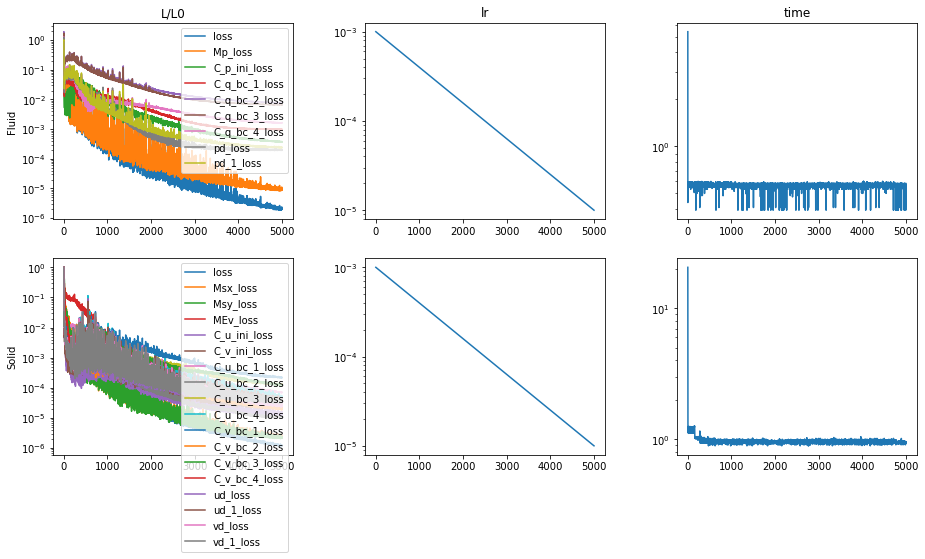


Total samples: 16400 
Batch size: 500 
Total batches: 33 


+ adaptive_weights at epoch 1: [0.15011856412968042, 1.0024468662031463, 0.9160078881311551, 2.164010431588023, 2.58190736498944, 0.8525519874748226, 0.16789653345359073, 0.16506047131850254]

+ adaptive_weights at epoch 301: [0.1351095422788859, 1.0087981766261043, 0.8877208164341641, 2.1823807560460455, 2.6009551986522568, 0.8717439348529907, 0.1599999925152112, 0.15329170329374744]

+ adaptive_weights at epoch 601: [0.12160227975462948, 0.9677094153667265, 0.8695112917854013, 2.2982712327761576, 2.547027268121215, 0.886149440964487, 0.14616279722627804, 0.16356630082719553]

+ adaptive_weights at epoch 901: [0.10944649050676444, 0.9851798298741542, 0.843720464609333, 2.275637109667168, 2.5899009924887793, 0.8943216139531206, 0.13414059269222914, 0.1676530000857677]

+ adaptive_weights at epoch 1201: [0.09850704026421737, 1.0240313953705966, 0.8127971654147883, 2.370385225340587, 2.47864099715036, 0.9319072769628024, 0.1271


+ adaptive_weights at epoch 3301: [0.06589440308071112, 0.05663287374705846, 0.3398315952751763, 0.4608725526953539, 1.8064714196607639, 1.6236173078363407, 2.352311875327467, 0.9167339438549689, 1.0116316613045964, 1.6103898660650366, 1.3851561385082143, 0.9276852062617607, 3.732483301937177, 0.10578051116839578, 0.13012107809711435, 0.35712604022592787, 0.11726046635274864]

+ adaptive_weights at epoch 3601: [0.062197758959483936, 0.05149805302727753, 0.35816964580205174, 0.45835557339182864, 1.696816261529202, 1.6012692738913326, 2.3016592317121005, 1.0601325730094202, 1.2284496806637792, 1.611985407564638, 1.4212067514519346, 0.8848936631144375, 3.5905161605070672, 0.09746700460230502, 0.12446286417087693, 0.338741286022989, 0.11217900839219083]

+ adaptive_weights at epoch 3901: [0.05881055103204734, 0.048107172794712015, 0.34355334799953174, 0.4630443410693851, 1.759886813672883, 1.570151315219611, 2.2102596151173817, 1.1193300218867177, 1.2593977190385306, 1.5569955221942866, 1

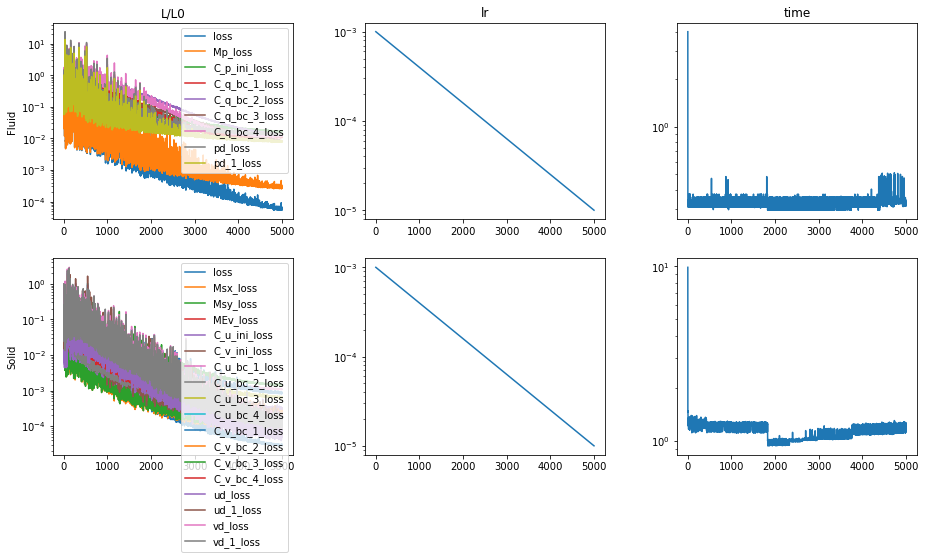


Total samples: 16400 
Batch size: 500 
Total batches: 33 


+ adaptive_weights at epoch 1: [0.0251997680893697, 1.8100075052332643, 0.5749637619433943, 2.285209923177897, 2.4098707784502493, 0.6502833748244026, 0.0634719027718943, 0.18099313470740563]

+ adaptive_weights at epoch 301: [0.02272437166061785, 1.778463332872505, 0.6148606337909485, 2.195130824026046, 2.4411823397589, 0.6954283197173463, 0.0877903244104367, 0.16442000463745726]

+ adaptive_weights at epoch 601: [0.020510761992265588, 1.7042766592758576, 0.6500652817248139, 2.190427760559587, 2.404415448824762, 0.7616416244745269, 0.11903404029916477, 0.14962863407298238]

+ adaptive_weights at epoch 901: [0.018532757685411544, 1.719841272106862, 0.6461463731110499, 2.186299464960763, 2.3825818633287117, 0.788525828761688, 0.10906976360587489, 0.14900284910684414]

+ adaptive_weights at epoch 1201: [0.016715902168529844, 1.8067445379223666, 0.6333005579282682, 2.177989239766623, 2.331714960589906, 0.7698201283446041, 0.1191


+ adaptive_weights at epoch 3301: [0.0474362187000083, 0.034039787017256184, 0.42612122308830813, 0.5495581841505945, 1.7081141734169591, 1.670073978923199, 2.938603510751583, 0.9280939201080146, 0.8778767405602498, 1.1422147659147845, 1.4307094510537937, 1.2782267772616767, 3.5148538731442662, 0.08485357861576312, 0.09379319955614016, 0.18832315355206333, 0.08710726301966384]

+ adaptive_weights at epoch 3601: [0.047072079014150434, 0.03200734633601933, 0.40606734094253893, 0.770978068340068, 1.7631785577113483, 1.584854985116064, 2.846720575484049, 0.9444480043348933, 0.863430489252699, 1.1827977388917525, 1.5337077910855674, 1.2084549229876653, 3.393700560125733, 0.07918647130789003, 0.08716241242978254, 0.17453495228443716, 0.08169747972033711]

+ adaptive_weights at epoch 3901: [0.04364263293395551, 0.031534176839183164, 0.41821879158621855, 0.759252899375495, 1.676260549197605, 1.5325009863773833, 2.7702071532142756, 0.9580201033599333, 0.8363728665135205, 1.1970968224228644, 1.

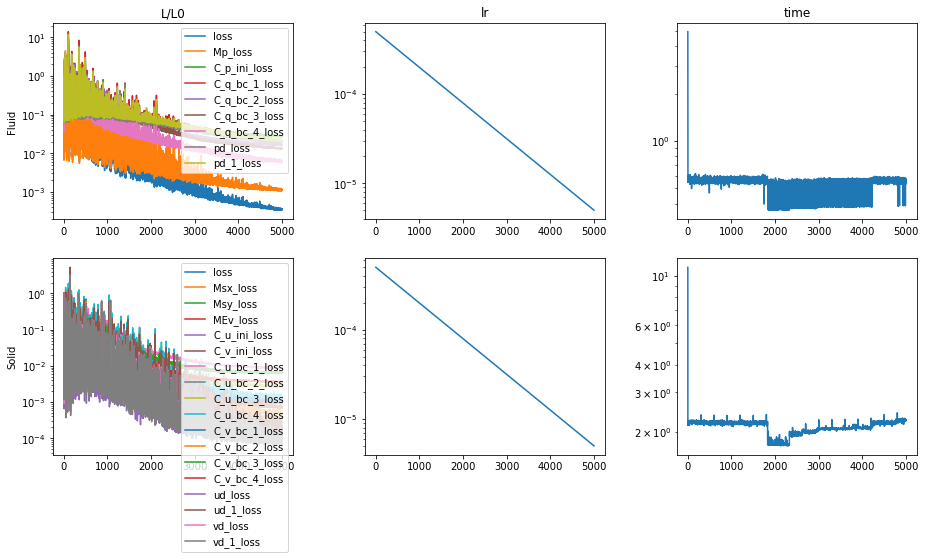


Total samples: 16400 
Batch size: 500 
Total batches: 33 


+ adaptive_weights at epoch 1: [0.006601257377648836, 2.4970759537922063, 0.7267526710671075, 1.5407276536328094, 2.1624584846082433, 0.7789610878978588, 0.1199247586678499, 0.16749817989493418]

+ adaptive_weights at epoch 301: [0.0062550462008595, 2.362452504648273, 0.7098501127063814, 1.6065621985906529, 2.2448294400327184, 0.7853212929804904, 0.11041424667114426, 0.17431519002071236]

+ adaptive_weights at epoch 601: [0.005956319915602313, 2.3636205889345727, 0.6991712335932465, 1.6170423482773233, 2.1923665518760185, 0.8122425068094259, 0.12706201943478487, 0.18253850533886895]

+ adaptive_weights at epoch 901: [0.005718215845784466, 2.284022843700299, 0.726765918690549, 1.6439787809834363, 2.175999093370299, 0.8219672264214972, 0.13656000426631282, 0.20498794186753164]

+ adaptive_weights at epoch 1201: [0.005745658369022307, 2.2583396433322225, 0.7619424388600725, 1.6338040020717743, 2.1770335116882413, 0.8130092838836


+ adaptive_weights at epoch 3301: [0.0543662858051785, 0.03617117011255097, 0.32456664430328347, 0.5892848617967514, 1.8629947038600851, 1.3705343806583006, 2.690350430552035, 1.0243994124613798, 0.8469280978094951, 0.9532061344582671, 1.974433806818182, 1.039277389123341, 3.872715538469346, 0.07409616201044128, 0.07091914519477488, 0.14262908860748233, 0.0731265635572367]

+ adaptive_weights at epoch 3601: [0.05093603658006846, 0.03755743469015977, 0.36775293080473764, 0.5617831726157094, 1.7933102305115953, 1.3511277637527357, 2.89085344624802, 0.988176298103647, 0.8230400084478426, 0.9047102530889003, 1.8301552019098435, 1.033906406174116, 4.025799611244228, 0.07065434652507283, 0.06742568625416027, 0.1338859934259522, 0.06892503880723862]

+ adaptive_weights at epoch 3901: [0.054359386923279095, 0.03847775926784057, 0.385352595621257, 0.6116177631562241, 1.7947719025205298, 1.3318412535723188, 2.9019804441913495, 1.1711768523370176, 0.8575383565994988, 0.9091169838787604, 1.719717

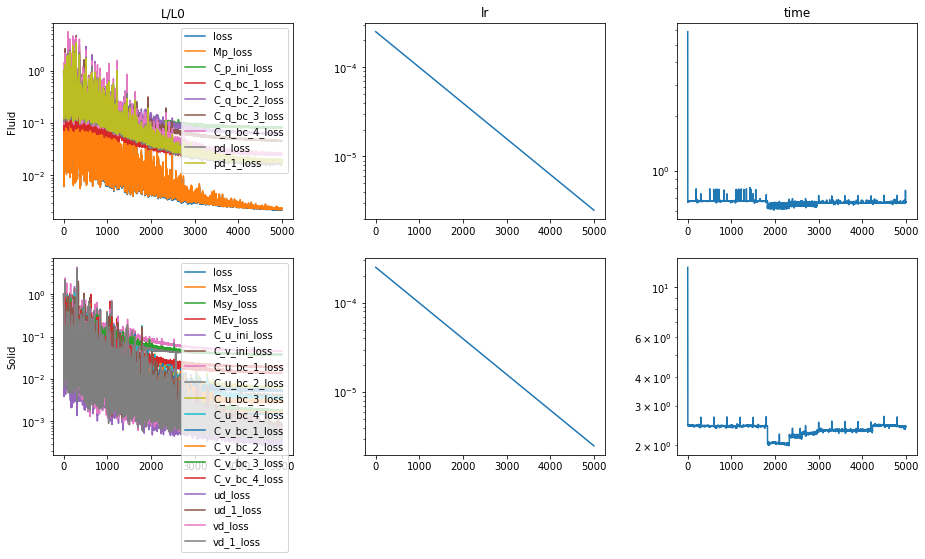

In [13]:
# ---------------------Sequential Training Algorithm---------------------------
n_itr = 4
parameter_fluid, parameter_solid = [],[]
Svd_td_data = np.zeros_like(t_data)
start_time = time.time()

initial_lr = 1e-3
final_lr = initial_lr / 100
for itr in range(n_itr):
    
    itr_time = time.time()
    if itr == 0:
        kwrds = {'adaptive_weights': ADAPTIVE_WEIGHTS}
    else:
        kwrds = {}
    if itr >= 2:
        initial_lr = initial_lr/2
        final_lr = initial_lr / 100

    ud.set_trainable(False)
    vd.set_trainable(False)
    Evd.set_trainable(False)
    pd.set_trainable(True)
    k_bar.set_trainable(True)
    E_bar.set_trainable(False)
    fluid.compile()
    H_fluid = fluid.train(
                  [x_data, y_data, t_data, Svd_td_data],
                  6*['zeros'] +[(x_sensor_ids, pd_true_sensor_Xprescribed)]+[(y_sensor_ids, pd_true_sensor_Yprescribed)],
                  learning_rate={"scheduler": "ExponentialDecay",
                                 "initial_learning_rate": initial_lr,
                                 "final_learning_rate": final_lr,
                                 "decay_epochs": EPOCHS_FLUID
                                 },
                  epochs=EPOCHS_FLUID,
                  batch_size=BATCH_SIZE,
                  stop_loss_value=1e-8,
                  stop_after=STOP_AFTER,
                  verbose=0,
                  log_parameters={'parameters': k_bar, 'freq': 1},
                  **kwrds)

    fluid.save_weights('FluidWeights_itr{:02d}.hdf5'.format(itr+1))

    ud.set_trainable(True)
    vd.set_trainable(True)
    Evd.set_trainable(True)
    pd.set_trainable(False)
    k_bar.set_trainable(False)
    E_bar.set_trainable(True)
    solid.compile()

    H_solid = solid.train(
                  [x_data, y_data, t_data],
                  13*['zeros'] + [(x_sensor_ids, ud_true_sensor_Xprescribed)] + 
                     [(y_sensor_ids, ud_true_sensor_Yprescribed)] + [(x_sensor_ids, vd_true_sensor_Xprescribed)] + 
                     [(y_sensor_ids, vd_true_sensor_Yprescribed)],
                  learning_rate={"scheduler": "ExponentialDecay",
                                 "initial_learning_rate": initial_lr,
                                 "final_learning_rate": final_lr,
                                 "decay_epochs": EPOCHS_SOLID
                                 },
                  epochs=EPOCHS_SOLID,
                  batch_size=BATCH_SIZE,
                  stop_loss_value=1e-8,
                  stop_after=STOP_AFTER,
                  verbose=0,
                  log_parameters={'parameters': E_bar, 'freq': 1},
                  **kwrds)

    solid.save_weights('SolidWeights_itr{:02d}.hdf5'.format(itr+1))
    Svd_td_data = Svd_td.eval(model_pred, input_data)

    parameter_fluid += H_fluid.history['k_bar']
    parameter_solid += H_solid.history['E_bar']


    print('\n -- iteration {} is completed in {}s, total in {}s... \n'.format(
        itr+1, time.time()-itr_time, time.time()-start_time)
     )
    Loss_Plot(H_fluid, H_solid, itr)

    pred = {
        'p_point1': pd.eval(model_pred, input_test_point1) * p_star / MPa,
        'p_true_point1': p_true_point1,
        'p_point2': pd.eval(model_pred, input_test_point2) * p_star / MPa,
        'p_true_point2': p_true_point2,
        'p_point3': pd.eval(model_pred, input_test_point3) * p_star / MPa,
        'p_true_point3': p_true_point3,
        'u_point1': ud.eval(model_pred, input_test_point1) * u_star / m,
        'u_true_point1': u_true_point1,
        'u_point2': ud.eval(model_pred, input_test_point2) * u_star / m,
        'u_true_point2': u_true_point2,
        'u_point3': ud.eval(model_pred, input_test_point3) * u_star / m,
        'u_true_point3': u_true_point3,
        'v_point1': vd.eval(model_pred, input_test_point1) * u_star / m,
        'v_true_point1': v_true_point1,
        'v_point2': vd.eval(model_pred, input_test_point2) * u_star / m,
        'v_true_point2': v_true_point2,
        'v_point3': vd.eval(model_pred, input_test_point3) * u_star / m,
        'v_true_point3': v_true_point3
    }


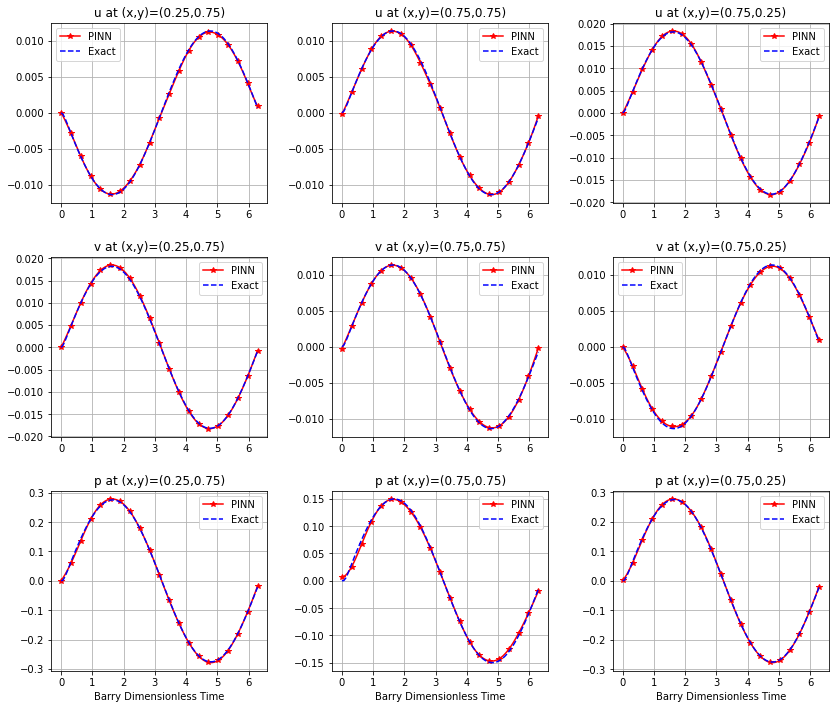

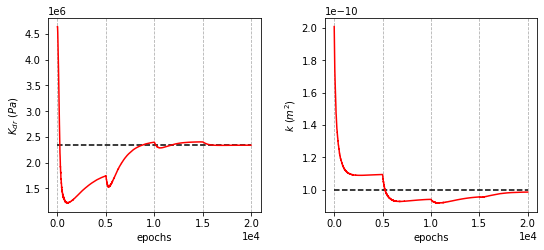

In [14]:
# -------Plots----------

Line_Plot(input_test_point1, input_test_point2, input_test_point3, pred, itr)

Parameter_Plot_Itr(parameter_solid, parameter_fluid, itr)